#### TO DO:
- Study RandCropByPosNegLabeld
- Hyperparameter Tuning for Unet
- Number of workers
- ~~Normalization~~
- Spatial size set to 256: Full Pass!
- Are they using Softmax?
- Experiment with Augmentations
- Random Patches

In [1]:
import numpy as np
import torch
import os
from glob import glob
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import albumentations as A


import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
# from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
)
from monai.visualize import plot_2d_or_3d_image

In [2]:
path2train_images = Path("/scratch/scratch6/akansh12/ravir_data/RAVIR Dataset/train/training_images/")
path2train_mask = Path("/scratch/scratch6/akansh12/ravir_data/ravir/data/training_images_masks/")
path2test_images = Path("/scratch/scratch6/akansh12/ravir_data/RAVIR Dataset/test/")

In [3]:
class ravir_dataset():
    def __init__(self, img_dir, mask_dir, transform = None, data_type = 'train'):
        self.segs_dir = None
        if data_type == 'train':
            self.images_dir = sorted(glob(os.path.join(path2train_images, "*.png")))[:19]
            self.segs_dir = sorted(glob(os.path.join(path2train_mask, "*.npy")))[:19]
        if data_type == "val":
            self.images_dir = sorted(glob(os.path.join(path2train_images, "*.png")))[19:]
            self.segs_dir = sorted(glob(os.path.join(path2train_mask, "*.npy")))[19:]
        self.transform = transform
        
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, idx):
        img = np.array(Image.open(self.images_dir[idx])).astype('uint8')
        
        if self.segs_dir is not None:
            seg = np.load(self.segs_dir[idx]).astype('uint8')
            img = self.transform(img)
            return img, torch.FloatTensor(seg)
        else:
            img = self.transform(img)
            return img

In [4]:
train_dataset = ravir_dataset(path2train_images, path2train_mask, transform=transforms.ToTensor(), data_type='train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

In [5]:
for x,y in train_dataset:
    print(x.shape)
    print(y.shape)
    break

torch.Size([1, 768, 768])
torch.Size([768, 768, 3])


### Normalization 

In [52]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0,0,0

    for data,_ in tqdm(loader):
        channels_sum += torch.mean(data, dim = [0,2,3])
        channels_squared_sum += torch.mean(data**2, dim = [0,2,3])
        num_batches += 1

    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5

    return mean, std

In [56]:
get_mean_std(train_loader)
#(tensor([0.4050]), tensor([0.1407]))

  0%|          | 0/3 [00:00<?, ?it/s]

(tensor([0.4050]), tensor([0.1407]))

### new_dataset

In [6]:
class ravir_dataset():
    def __init__(self, img_dir, mask_dir, transform = None, data_type = 'train'):
        self.segs_dir = None
        if data_type == 'train':
            self.images_dir = sorted(glob(os.path.join(img_dir, "*.png")))[:19]
            self.segs_dir = sorted(glob(os.path.join(mask_dir, "*.npy")))[:19]
        if data_type == "val":
            self.images_dir = sorted(glob(os.path.join(img_dir, "*.png")))[19:]
            self.segs_dir = sorted(glob(os.path.join(mask_dir, "*.npy")))[19:]
        if data_type == 'test':
            self.images_dir = sorted(glob(os.path.join(img_dir, "*.png")))
            
        self.transform = transform
        self.norm_transform = A.Normalize(mean = (0.4050), std = (0.1407))
        
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, idx):
        img = np.array(Image.open(self.images_dir[idx])).astype('uint8')
        
        if self.segs_dir is not None:
            seg = np.load(self.segs_dir[idx]).astype('uint8')
            augmented = self.transform(image=img, mask=seg)
            img = augmented['image']
            seg = augmented['mask']
            img = self.norm_transform(image = img)['image']
            return torch.tensor(img).unsqueeze(0), torch.FloatTensor(seg)
        else:
            augmented = self.transform(image=img)
            img = augmented['image']
            img = self.norm_transform(image = img)['image']
            return torch.tensor(img).unsqueeze(0)

### Transforms and Augmentations

In [7]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p = 0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate((-30,30), p = 0.5),
#     A.ElasticTransform(p=0.5, alpha=1, sigma=50, alpha_affine=10),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.3),
#     A.GridDistortion(p=0.5),
#     A.OpticalDistortion(distort_limit=0.8, shift_limit=0.6, p=0.5),
#     A.RandomSizedCrop(min_max_height=(150, 200), height=224, width=224, p=0.5),
#     A.CLAHE(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.RandomGamma(p = 0.5),
#     A.GaussianBlur(p = 0.5),
#     A.GaussNoise(p = 0.5), 
    
        ])


test_transforms = A.Compose([
    A.Rotate(0, p = 1)
        ])

### Dataset and Dataloader

In [8]:
train_dataset = ravir_dataset(path2train_images, path2train_mask, transform=train_transforms, data_type='train')
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

val_dataset = ravir_dataset(path2train_images, path2train_mask, transform=test_transforms, data_type='val')
print(len(val_dataset))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

test_dataset = ravir_dataset(path2test_images, None, transform=test_transforms, data_type='test')
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

19
4
19


In [9]:
for x,y in train_dataset:
    print(x.shape)
    print(y.shape)
    break
for x,y in val_dataset:
    print(x.shape)
    print(y.shape)
    break
for x in test_dataset:
    print(x.shape)
    break

torch.Size([1, 768, 768])
torch.Size([768, 768, 3])
torch.Size([1, 768, 768])
torch.Size([768, 768, 3])
torch.Size([1, 768, 768])


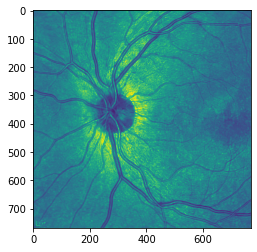

In [134]:
plt.imshow(x.numpy())

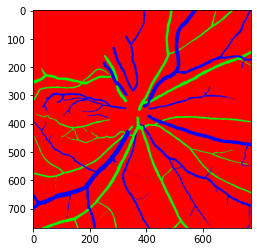

In [135]:
plt.imshow(y)

### Model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,  #2D UNET
    in_channels=1,
    out_channels=3,  #Background, Artery, Veins
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=0,
).to(device)

### Loss, Metric and Optimizer

In [11]:
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
loss_function = monai.losses.DiceCELoss(softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
post_trans = Compose([Activations(softmax=True), AsDiscrete(threshold=0.5)])

### Model Training

In [12]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

writer = SummaryWriter()
epochs = 600
for epoch in range(epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epochs}")
    model.train()
    epoch_loss = 0
    val_epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device).permute(0,3,1,2)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    model.eval()
    with torch.no_grad():
        val_images = None
        val_labels = None
        val_outputs = None
        val_step = 0
        for val_data in val_loader:
            val_step+=1
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device).permute(0,3,1,2)
            val_outputs = model(val_images)
            val_loss = loss_function(val_outputs,val_labels)
            val_epoch_loss += val_loss.item()
            epoch_len = len(val_dataset) // val_loader.batch_size
            print(f"{val_step}/{epoch_len}, val_loss: {val_loss.item():.4f}")
            writer.add_scalar("val_loss", val_loss.item(), epoch_len * epoch + step)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels)
        # aggregate the final mean dice result
        metric = dice_metric.aggregate().item()
        # reset the status for next validation round
        dice_metric.reset()
        metric_values.append(metric)
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "/scratch/scratch6/akansh12/ravir_data/ravir/temp/baseline.pth")
            print("saved new best metric model")
        print(
            "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                epoch + 1, metric, best_metric, best_metric_epoch
            )
        )
        writer.add_scalar("val_mean_dice", metric, epoch + 1)
        # plot the last model output as GIF image in TensorBoard with the corresponding image and label
        plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
        plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
        plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output", max_channels = 3)

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/600
1/9, train_loss: 2.1701
2/9, train_loss: 2.0957
3/9, train_loss: 2.0085
4/9, train_loss: 1.9745
5/9, train_loss: 1.9550
6/9, train_loss: 1.9176
7/9, train_loss: 1.8750
8/9, train_loss: 1.8409
9/9, train_loss: 1.7979
10/9, train_loss: 1.7716
epoch 1 average loss: 1.9407
1/2, val_loss: 1.7301
2/2, val_loss: 1.7127
saved new best metric model
current epoch: 1 current mean dice: 0.1382 best mean dice: 0.1382 at epoch 1
----------
epoch 2/600
1/9, train_loss: 1.7480
2/9, train_loss: 1.7229
3/9, train_loss: 1.6967
4/9, train_loss: 1.6909
5/9, train_loss: 1.6652
6/9, train_loss: 1.6103
7/9, train_loss: 1.5934
8/9, train_loss: 1.5740
9/9, train_loss: 1.5734
10/9, train_loss: 1.5150
epoch 2 average loss: 1.6390
1/2, val_loss: 1.5072
2/2, val_loss: 1.4926
saved new best metric model
current epoch: 2 current mean dice: 0.1719 best mean dice: 0.1719 at epoch 2
----------
epoch 3/600
1/9, train_loss: 1.5453
2/9, train_loss: 1.5228
3/9, train_loss: 1.4641
4/9, train_loss: 1.46

10/9, train_loss: 0.6395
epoch 19 average loss: 0.6525
1/2, val_loss: 0.6985
2/2, val_loss: 0.7197
saved new best metric model
current epoch: 19 current mean dice: 0.4777 best mean dice: 0.4777 at epoch 19
----------
epoch 20/600
1/9, train_loss: 0.6124
2/9, train_loss: 0.6518
3/9, train_loss: 0.6040
4/9, train_loss: 0.6143
5/9, train_loss: 0.7099
6/9, train_loss: 0.6157
7/9, train_loss: 0.6024
8/9, train_loss: 0.7094
9/9, train_loss: 0.5878
10/9, train_loss: 0.7850
epoch 20 average loss: 0.6493
1/2, val_loss: 0.7263
2/2, val_loss: 0.7267
current epoch: 20 current mean dice: 0.4652 best mean dice: 0.4777 at epoch 19
----------
epoch 21/600
1/9, train_loss: 0.6035
2/9, train_loss: 0.6022
3/9, train_loss: 0.6159
4/9, train_loss: 0.6702
5/9, train_loss: 0.6308
6/9, train_loss: 0.6318
7/9, train_loss: 0.6078
8/9, train_loss: 0.6501
9/9, train_loss: 0.6521
10/9, train_loss: 0.7466
epoch 21 average loss: 0.6411
1/2, val_loss: 0.6846
2/2, val_loss: 0.7265
saved new best metric model
current e

9/9, train_loss: 0.5256
10/9, train_loss: 0.4695
epoch 38 average loss: 0.5140
1/2, val_loss: 0.5975
2/2, val_loss: 0.6512
current epoch: 38 current mean dice: 0.5554 best mean dice: 0.5628 at epoch 36
----------
epoch 39/600
1/9, train_loss: 0.5843
2/9, train_loss: 0.4780
3/9, train_loss: 0.4389
4/9, train_loss: 0.5427
5/9, train_loss: 0.5799
6/9, train_loss: 0.4867
7/9, train_loss: 0.4962
8/9, train_loss: 0.5986
9/9, train_loss: 0.4473
10/9, train_loss: 0.4589
epoch 39 average loss: 0.5112
1/2, val_loss: 0.5809
2/2, val_loss: 0.6597
current epoch: 39 current mean dice: 0.5574 best mean dice: 0.5628 at epoch 36
----------
epoch 40/600
1/9, train_loss: 0.5102
2/9, train_loss: 0.6526
3/9, train_loss: 0.4995
4/9, train_loss: 0.4714
5/9, train_loss: 0.4666
6/9, train_loss: 0.4771
7/9, train_loss: 0.3963
8/9, train_loss: 0.5150
9/9, train_loss: 0.5238
10/9, train_loss: 0.4707
epoch 40 average loss: 0.4983
1/2, val_loss: 0.6034
2/2, val_loss: 0.6638
current epoch: 40 current mean dice: 0.54

2/2, val_loss: 0.6440
current epoch: 57 current mean dice: 0.5626 best mean dice: 0.5805 at epoch 54
----------
epoch 58/600
1/9, train_loss: 0.4071
2/9, train_loss: 0.4157
3/9, train_loss: 0.4820
4/9, train_loss: 0.5421
5/9, train_loss: 0.3566
6/9, train_loss: 0.4588
7/9, train_loss: 0.5336
8/9, train_loss: 0.4861
9/9, train_loss: 0.4855
10/9, train_loss: 0.4759
epoch 58 average loss: 0.4643
1/2, val_loss: 0.5534
2/2, val_loss: 0.6252
saved new best metric model
current epoch: 58 current mean dice: 0.5874 best mean dice: 0.5874 at epoch 58
----------
epoch 59/600
1/9, train_loss: 0.4339
2/9, train_loss: 0.4959
3/9, train_loss: 0.4734
4/9, train_loss: 0.4721
5/9, train_loss: 0.4374
6/9, train_loss: 0.4293
7/9, train_loss: 0.4433
8/9, train_loss: 0.5294
9/9, train_loss: 0.4936
10/9, train_loss: 0.4255
epoch 59 average loss: 0.4634
1/2, val_loss: 0.5964
2/2, val_loss: 0.6383
current epoch: 59 current mean dice: 0.5675 best mean dice: 0.5874 at epoch 58
----------
epoch 60/600
1/9, train_

4/9, train_loss: 0.4421
5/9, train_loss: 0.3963
6/9, train_loss: 0.3559
7/9, train_loss: 0.4918
8/9, train_loss: 0.3901
9/9, train_loss: 0.4207
10/9, train_loss: 0.4962
epoch 77 average loss: 0.4338
1/2, val_loss: 0.5732
2/2, val_loss: 0.6342
current epoch: 77 current mean dice: 0.5836 best mean dice: 0.5912 at epoch 76
----------
epoch 78/600
1/9, train_loss: 0.3818
2/9, train_loss: 0.4072
3/9, train_loss: 0.3919
4/9, train_loss: 0.3613
5/9, train_loss: 0.4487
6/9, train_loss: 0.4752
7/9, train_loss: 0.4048
8/9, train_loss: 0.5638
9/9, train_loss: 0.3907
10/9, train_loss: 0.5744
epoch 78 average loss: 0.4400
1/2, val_loss: 0.5646
2/2, val_loss: 0.6227
current epoch: 78 current mean dice: 0.5882 best mean dice: 0.5912 at epoch 76
----------
epoch 79/600
1/9, train_loss: 0.3660
2/9, train_loss: 0.4220
3/9, train_loss: 0.4182
4/9, train_loss: 0.4351
5/9, train_loss: 0.3635
6/9, train_loss: 0.3920
7/9, train_loss: 0.4470
8/9, train_loss: 0.4774
9/9, train_loss: 0.5026
10/9, train_loss: 0.

----------
epoch 97/600
1/9, train_loss: 0.3608
2/9, train_loss: 0.3829
3/9, train_loss: 0.3649
4/9, train_loss: 0.4087
5/9, train_loss: 0.3902
6/9, train_loss: 0.5214
7/9, train_loss: 0.4683
8/9, train_loss: 0.3852
9/9, train_loss: 0.4061
10/9, train_loss: 0.5795
epoch 97 average loss: 0.4268
1/2, val_loss: 0.5723
2/2, val_loss: 0.6321
current epoch: 97 current mean dice: 0.5882 best mean dice: 0.5925 at epoch 93
----------
epoch 98/600
1/9, train_loss: 0.3786
2/9, train_loss: 0.5124
3/9, train_loss: 0.4032
4/9, train_loss: 0.4112
5/9, train_loss: 0.4061
6/9, train_loss: 0.4671
7/9, train_loss: 0.3784
8/9, train_loss: 0.3505
9/9, train_loss: 0.4101
10/9, train_loss: 0.3696
epoch 98 average loss: 0.4087
1/2, val_loss: 0.5518
2/2, val_loss: 0.6325
current epoch: 98 current mean dice: 0.5889 best mean dice: 0.5925 at epoch 93
----------
epoch 99/600
1/9, train_loss: 0.3916
2/9, train_loss: 0.4490
3/9, train_loss: 0.5606
4/9, train_loss: 0.4042
5/9, train_loss: 0.3782
6/9, train_loss: 0.3

6/9, train_loss: 0.3436
7/9, train_loss: 0.4733
8/9, train_loss: 0.3362
9/9, train_loss: 0.4110
10/9, train_loss: 0.4299
epoch 116 average loss: 0.3889
1/2, val_loss: 0.5602
2/2, val_loss: 0.6197
current epoch: 116 current mean dice: 0.5979 best mean dice: 0.6049 at epoch 113
----------
epoch 117/600
1/9, train_loss: 0.4547
2/9, train_loss: 0.3464
3/9, train_loss: 0.4072
4/9, train_loss: 0.3354
5/9, train_loss: 0.3788
6/9, train_loss: 0.4605
7/9, train_loss: 0.3914
8/9, train_loss: 0.3693
9/9, train_loss: 0.4279
10/9, train_loss: 0.5399
epoch 117 average loss: 0.4112
1/2, val_loss: 0.5556
2/2, val_loss: 0.6191
current epoch: 117 current mean dice: 0.5987 best mean dice: 0.6049 at epoch 113
----------
epoch 118/600
1/9, train_loss: 0.3465
2/9, train_loss: 0.4383
3/9, train_loss: 0.4135
4/9, train_loss: 0.3682
5/9, train_loss: 0.4088
6/9, train_loss: 0.3283
7/9, train_loss: 0.3031
8/9, train_loss: 0.3625
9/9, train_loss: 0.3957
10/9, train_loss: 0.3027
epoch 118 average loss: 0.3667
1/2,

----------
epoch 136/600
1/9, train_loss: 0.4037
2/9, train_loss: 0.4214
3/9, train_loss: 0.4079
4/9, train_loss: 0.4069
5/9, train_loss: 0.4385
6/9, train_loss: 0.4266
7/9, train_loss: 0.3030
8/9, train_loss: 0.4230
9/9, train_loss: 0.4829
10/9, train_loss: 0.2464
epoch 136 average loss: 0.3960
1/2, val_loss: 0.5737
2/2, val_loss: 0.6260
current epoch: 136 current mean dice: 0.5881 best mean dice: 0.6049 at epoch 113
----------
epoch 137/600
1/9, train_loss: 0.4070
2/9, train_loss: 0.3369
3/9, train_loss: 0.3730
4/9, train_loss: 0.4003
5/9, train_loss: 0.3797
6/9, train_loss: 0.3054
7/9, train_loss: 0.3352
8/9, train_loss: 0.3353
9/9, train_loss: 0.4946
10/9, train_loss: 0.3807
epoch 137 average loss: 0.3748
1/2, val_loss: 0.5675
2/2, val_loss: 0.6404
current epoch: 137 current mean dice: 0.5890 best mean dice: 0.6049 at epoch 113
----------
epoch 138/600
1/9, train_loss: 0.3832
2/9, train_loss: 0.4629
3/9, train_loss: 0.3870
4/9, train_loss: 0.3946
5/9, train_loss: 0.4253
6/9, train_

8/9, train_loss: 0.3179
9/9, train_loss: 0.4600
10/9, train_loss: 0.2226
epoch 155 average loss: 0.3696
1/2, val_loss: 0.5534
2/2, val_loss: 0.6243
current epoch: 155 current mean dice: 0.6010 best mean dice: 0.6049 at epoch 113
----------
epoch 156/600
1/9, train_loss: 0.3710
2/9, train_loss: 0.3201
3/9, train_loss: 0.3561
4/9, train_loss: 0.3709
5/9, train_loss: 0.4403
6/9, train_loss: 0.4054
7/9, train_loss: 0.3156
8/9, train_loss: 0.3632
9/9, train_loss: 0.4008
10/9, train_loss: 0.2399
epoch 156 average loss: 0.3583
1/2, val_loss: 0.5657
2/2, val_loss: 0.6284
current epoch: 156 current mean dice: 0.5937 best mean dice: 0.6049 at epoch 113
----------
epoch 157/600
1/9, train_loss: 0.4360
2/9, train_loss: 0.2963
3/9, train_loss: 0.3317
4/9, train_loss: 0.3957
5/9, train_loss: 0.3121
6/9, train_loss: 0.3717
7/9, train_loss: 0.3932
8/9, train_loss: 0.4113
9/9, train_loss: 0.4112
10/9, train_loss: 0.3625
epoch 157 average loss: 0.3722
1/2, val_loss: 0.5612
2/2, val_loss: 0.6297
current 

----------
epoch 175/600
1/9, train_loss: 0.2849
2/9, train_loss: 0.3365
3/9, train_loss: 0.3299
4/9, train_loss: 0.4656
5/9, train_loss: 0.3289
6/9, train_loss: 0.2746
7/9, train_loss: 0.4608
8/9, train_loss: 0.4189
9/9, train_loss: 0.2620
10/9, train_loss: 0.3194
epoch 175 average loss: 0.3482
1/2, val_loss: 0.5876
2/2, val_loss: 0.6343
current epoch: 175 current mean dice: 0.5881 best mean dice: 0.6049 at epoch 113
----------
epoch 176/600
1/9, train_loss: 0.3503
2/9, train_loss: 0.4343
3/9, train_loss: 0.4281
4/9, train_loss: 0.4104
5/9, train_loss: 0.3079
6/9, train_loss: 0.3489
7/9, train_loss: 0.3777
8/9, train_loss: 0.3382
9/9, train_loss: 0.3674
10/9, train_loss: 0.3812
epoch 176 average loss: 0.3744
1/2, val_loss: 0.5881
2/2, val_loss: 0.6387
current epoch: 176 current mean dice: 0.5914 best mean dice: 0.6049 at epoch 113
----------
epoch 177/600
1/9, train_loss: 0.3233
2/9, train_loss: 0.2783
3/9, train_loss: 0.3623
4/9, train_loss: 0.3330
5/9, train_loss: 0.3273
6/9, train_

7/9, train_loss: 0.2362
8/9, train_loss: 0.3857
9/9, train_loss: 0.2991
10/9, train_loss: 0.4915
epoch 194 average loss: 0.3678
1/2, val_loss: 0.5743
2/2, val_loss: 0.6214
current epoch: 194 current mean dice: 0.5997 best mean dice: 0.6068 at epoch 193
----------
epoch 195/600
1/9, train_loss: 0.2573
2/9, train_loss: 0.2762
3/9, train_loss: 0.3270
4/9, train_loss: 0.3627
5/9, train_loss: 0.3904
6/9, train_loss: 0.3103
7/9, train_loss: 0.3736
8/9, train_loss: 0.4071
9/9, train_loss: 0.3015
10/9, train_loss: 0.2440
epoch 195 average loss: 0.3250
1/2, val_loss: 0.5610
2/2, val_loss: 0.6261
current epoch: 195 current mean dice: 0.6028 best mean dice: 0.6068 at epoch 193
----------
epoch 196/600
1/9, train_loss: 0.3102
2/9, train_loss: 0.4276
3/9, train_loss: 0.4183
4/9, train_loss: 0.4303
5/9, train_loss: 0.3089
6/9, train_loss: 0.2950
7/9, train_loss: 0.2973
8/9, train_loss: 0.3390
9/9, train_loss: 0.3209
10/9, train_loss: 0.2374
epoch 196 average loss: 0.3385
1/2, val_loss: 0.5668
2/2, v

2/2, val_loss: 0.6512
current epoch: 213 current mean dice: 0.5830 best mean dice: 0.6096 at epoch 201
----------
epoch 214/600
1/9, train_loss: 0.3422
2/9, train_loss: 0.4335
3/9, train_loss: 0.2764
4/9, train_loss: 0.3491
5/9, train_loss: 0.2797
6/9, train_loss: 0.4477
7/9, train_loss: 0.3366
8/9, train_loss: 0.3475
9/9, train_loss: 0.3501
10/9, train_loss: 0.2363
epoch 214 average loss: 0.3399
1/2, val_loss: 0.5606
2/2, val_loss: 0.6508
current epoch: 214 current mean dice: 0.5959 best mean dice: 0.6096 at epoch 201
----------
epoch 215/600
1/9, train_loss: 0.2785
2/9, train_loss: 0.3722
3/9, train_loss: 0.3350
4/9, train_loss: 0.3265
5/9, train_loss: 0.3064
6/9, train_loss: 0.2927
7/9, train_loss: 0.3536
8/9, train_loss: 0.3078
9/9, train_loss: 0.4114
10/9, train_loss: 0.3535
epoch 215 average loss: 0.3338
1/2, val_loss: 0.5797
2/2, val_loss: 0.6388
current epoch: 215 current mean dice: 0.5977 best mean dice: 0.6096 at epoch 201
----------
epoch 216/600
1/9, train_loss: 0.3603
2/9,

3/9, train_loss: 0.4669
4/9, train_loss: 0.3258
5/9, train_loss: 0.3495
6/9, train_loss: 0.3242
7/9, train_loss: 0.3915
8/9, train_loss: 0.2736
9/9, train_loss: 0.3487
10/9, train_loss: 0.4308
epoch 233 average loss: 0.3569
1/2, val_loss: 0.5765
2/2, val_loss: 0.6466
current epoch: 233 current mean dice: 0.5919 best mean dice: 0.6096 at epoch 201
----------
epoch 234/600
1/9, train_loss: 0.3392
2/9, train_loss: 0.3535
3/9, train_loss: 0.2250
4/9, train_loss: 0.3784
5/9, train_loss: 0.3908
6/9, train_loss: 0.3327
7/9, train_loss: 0.3263
8/9, train_loss: 0.3618
9/9, train_loss: 0.3655
10/9, train_loss: 0.2343
epoch 234 average loss: 0.3307
1/2, val_loss: 0.5700
2/2, val_loss: 0.6271
current epoch: 234 current mean dice: 0.5972 best mean dice: 0.6096 at epoch 201
----------
epoch 235/600
1/9, train_loss: 0.2564
2/9, train_loss: 0.3494
3/9, train_loss: 0.4456
4/9, train_loss: 0.4109
5/9, train_loss: 0.2423
6/9, train_loss: 0.3961
7/9, train_loss: 0.3339
8/9, train_loss: 0.3140
9/9, train_l

1/2, val_loss: 0.5687
2/2, val_loss: 0.6196
current epoch: 252 current mean dice: 0.6046 best mean dice: 0.6096 at epoch 201
----------
epoch 253/600
1/9, train_loss: 0.3153
2/9, train_loss: 0.3260
3/9, train_loss: 0.3413
4/9, train_loss: 0.2529
5/9, train_loss: 0.2780
6/9, train_loss: 0.3936
7/9, train_loss: 0.3941
8/9, train_loss: 0.3987
9/9, train_loss: 0.3195
10/9, train_loss: 0.3051
epoch 253 average loss: 0.3325
1/2, val_loss: 0.5642
2/2, val_loss: 0.6210
current epoch: 253 current mean dice: 0.6063 best mean dice: 0.6096 at epoch 201
----------
epoch 254/600
1/9, train_loss: 0.2935
2/9, train_loss: 0.2898
3/9, train_loss: 0.2347
4/9, train_loss: 0.2285
5/9, train_loss: 0.2816
6/9, train_loss: 0.3518
7/9, train_loss: 0.3836
8/9, train_loss: 0.2618
9/9, train_loss: 0.3371
10/9, train_loss: 0.3083
epoch 254 average loss: 0.2971
1/2, val_loss: 0.5757
2/2, val_loss: 0.6333
current epoch: 254 current mean dice: 0.5993 best mean dice: 0.6096 at epoch 201
----------
epoch 255/600
1/9, t

1/9, train_loss: 0.4031
2/9, train_loss: 0.3114
3/9, train_loss: 0.2507
4/9, train_loss: 0.3325
5/9, train_loss: 0.3622
6/9, train_loss: 0.2275
7/9, train_loss: 0.4289
8/9, train_loss: 0.3293
9/9, train_loss: 0.2605
10/9, train_loss: 0.2573
epoch 272 average loss: 0.3163
1/2, val_loss: 0.5981
2/2, val_loss: 0.6320
current epoch: 272 current mean dice: 0.5932 best mean dice: 0.6102 at epoch 266
----------
epoch 273/600
1/9, train_loss: 0.3355
2/9, train_loss: 0.2064
3/9, train_loss: 0.2924
4/9, train_loss: 0.3569
5/9, train_loss: 0.3776
6/9, train_loss: 0.5296
7/9, train_loss: 0.3487
8/9, train_loss: 0.2512
9/9, train_loss: 0.2821
10/9, train_loss: 0.2485
epoch 273 average loss: 0.3229
1/2, val_loss: 0.5798
2/2, val_loss: 0.6297
current epoch: 273 current mean dice: 0.5983 best mean dice: 0.6102 at epoch 266
----------
epoch 274/600
1/9, train_loss: 0.3555
2/9, train_loss: 0.3621
3/9, train_loss: 0.3228
4/9, train_loss: 0.3570
5/9, train_loss: 0.2557
6/9, train_loss: 0.3022
7/9, train_l

8/9, train_loss: 0.2315
9/9, train_loss: 0.3016
10/9, train_loss: 0.2835
epoch 291 average loss: 0.2966
1/2, val_loss: 0.5706
2/2, val_loss: 0.6406
current epoch: 291 current mean dice: 0.6020 best mean dice: 0.6126 at epoch 278
----------
epoch 292/600
1/9, train_loss: 0.3393
2/9, train_loss: 0.3196
3/9, train_loss: 0.2298
4/9, train_loss: 0.2677
5/9, train_loss: 0.3745
6/9, train_loss: 0.4377
7/9, train_loss: 0.2112
8/9, train_loss: 0.3485
9/9, train_loss: 0.3562
10/9, train_loss: 0.4895
epoch 292 average loss: 0.3374
1/2, val_loss: 0.6145
2/2, val_loss: 0.6433
current epoch: 292 current mean dice: 0.5855 best mean dice: 0.6126 at epoch 278
----------
epoch 293/600
1/9, train_loss: 0.2104
2/9, train_loss: 0.3211
3/9, train_loss: 0.3163
4/9, train_loss: 0.2922
5/9, train_loss: 0.3328
6/9, train_loss: 0.3642
7/9, train_loss: 0.3072
8/9, train_loss: 0.3339
9/9, train_loss: 0.2751
10/9, train_loss: 0.2528
epoch 293 average loss: 0.3006
1/2, val_loss: 0.5891
2/2, val_loss: 0.6499
current 

----------
epoch 311/600
1/9, train_loss: 0.3729
2/9, train_loss: 0.3740
3/9, train_loss: 0.2364
4/9, train_loss: 0.3193
5/9, train_loss: 0.2341
6/9, train_loss: 0.2488
7/9, train_loss: 0.2522
8/9, train_loss: 0.3056
9/9, train_loss: 0.3299
10/9, train_loss: 0.4456
epoch 311 average loss: 0.3119
1/2, val_loss: 0.5806
2/2, val_loss: 0.6399
current epoch: 311 current mean dice: 0.5977 best mean dice: 0.6126 at epoch 278
----------
epoch 312/600
1/9, train_loss: 0.4274
2/9, train_loss: 0.2916
3/9, train_loss: 0.3103
4/9, train_loss: 0.3542
5/9, train_loss: 0.2216
6/9, train_loss: 0.2600
7/9, train_loss: 0.3126
8/9, train_loss: 0.2773
9/9, train_loss: 0.2607
10/9, train_loss: 0.3336
epoch 312 average loss: 0.3049
1/2, val_loss: 0.5710
2/2, val_loss: 0.6135
current epoch: 312 current mean dice: 0.6093 best mean dice: 0.6126 at epoch 278
----------
epoch 313/600
1/9, train_loss: 0.3202
2/9, train_loss: 0.2770
3/9, train_loss: 0.3953
4/9, train_loss: 0.3929
5/9, train_loss: 0.3128
6/9, train_

7/9, train_loss: 0.2505
8/9, train_loss: 0.1740
9/9, train_loss: 0.2021
10/9, train_loss: 0.4261
epoch 330 average loss: 0.2701
1/2, val_loss: 0.5865
2/2, val_loss: 0.6339
current epoch: 330 current mean dice: 0.6030 best mean dice: 0.6128 at epoch 327
----------
epoch 331/600
1/9, train_loss: 0.2822
2/9, train_loss: 0.4237
3/9, train_loss: 0.1837
4/9, train_loss: 0.3117
5/9, train_loss: 0.4078
6/9, train_loss: 0.3504
7/9, train_loss: 0.1941
8/9, train_loss: 0.2633
9/9, train_loss: 0.3344
10/9, train_loss: 0.2297
epoch 331 average loss: 0.2981
1/2, val_loss: 0.6029
2/2, val_loss: 0.6346
current epoch: 331 current mean dice: 0.5976 best mean dice: 0.6128 at epoch 327
----------
epoch 332/600
1/9, train_loss: 0.2706
2/9, train_loss: 0.2635
3/9, train_loss: 0.2721
4/9, train_loss: 0.3149
5/9, train_loss: 0.3213
6/9, train_loss: 0.4173
7/9, train_loss: 0.3512
8/9, train_loss: 0.3481
9/9, train_loss: 0.3308
10/9, train_loss: 0.2464
epoch 332 average loss: 0.3136
1/2, val_loss: 0.5992
2/2, v

2/2, val_loss: 0.6344
current epoch: 349 current mean dice: 0.5946 best mean dice: 0.6146 at epoch 333
----------
epoch 350/600
1/9, train_loss: 0.3321
2/9, train_loss: 0.3970
3/9, train_loss: 0.3539
4/9, train_loss: 0.3098
5/9, train_loss: 0.3672
6/9, train_loss: 0.2357
7/9, train_loss: 0.2639
8/9, train_loss: 0.2594
9/9, train_loss: 0.3512
10/9, train_loss: 0.4576
epoch 350 average loss: 0.3328
1/2, val_loss: 0.5670
2/2, val_loss: 0.6321
current epoch: 350 current mean dice: 0.6062 best mean dice: 0.6146 at epoch 333
----------
epoch 351/600
1/9, train_loss: 0.3531
2/9, train_loss: 0.2712
3/9, train_loss: 0.2709
4/9, train_loss: 0.2071
5/9, train_loss: 0.3213
6/9, train_loss: 0.3313
7/9, train_loss: 0.2569
8/9, train_loss: 0.2823
9/9, train_loss: 0.3547
10/9, train_loss: 0.2676
epoch 351 average loss: 0.2916
1/2, val_loss: 0.5765
2/2, val_loss: 0.6308
current epoch: 351 current mean dice: 0.6022 best mean dice: 0.6146 at epoch 333
----------
epoch 352/600
1/9, train_loss: 0.2332
2/9,

3/9, train_loss: 0.3433
4/9, train_loss: 0.2393
5/9, train_loss: 0.3387
6/9, train_loss: 0.2838
7/9, train_loss: 0.3051
8/9, train_loss: 0.3440
9/9, train_loss: 0.2935
10/9, train_loss: 0.2357
epoch 369 average loss: 0.2958
1/2, val_loss: 0.5975
2/2, val_loss: 0.6486
current epoch: 369 current mean dice: 0.5976 best mean dice: 0.6146 at epoch 333
----------
epoch 370/600
1/9, train_loss: 0.4149
2/9, train_loss: 0.3453
3/9, train_loss: 0.2783
4/9, train_loss: 0.3069
5/9, train_loss: 0.3241
6/9, train_loss: 0.3680
7/9, train_loss: 0.2358
8/9, train_loss: 0.2683
9/9, train_loss: 0.2737
10/9, train_loss: 0.2025
epoch 370 average loss: 0.3018
1/2, val_loss: 0.5708
2/2, val_loss: 0.6231
current epoch: 370 current mean dice: 0.6096 best mean dice: 0.6146 at epoch 333
----------
epoch 371/600
1/9, train_loss: 0.1981
2/9, train_loss: 0.2331
3/9, train_loss: 0.2908
4/9, train_loss: 0.3192
5/9, train_loss: 0.1972
6/9, train_loss: 0.3451
7/9, train_loss: 0.2723
8/9, train_loss: 0.2430
9/9, train_l

10/9, train_loss: 0.2878
epoch 388 average loss: 0.2819
1/2, val_loss: 0.5761
2/2, val_loss: 0.6199
current epoch: 388 current mean dice: 0.6095 best mean dice: 0.6168 at epoch 381
----------
epoch 389/600
1/9, train_loss: 0.2855
2/9, train_loss: 0.3388
3/9, train_loss: 0.3244
4/9, train_loss: 0.2762
5/9, train_loss: 0.3066
6/9, train_loss: 0.2587
7/9, train_loss: 0.3452
8/9, train_loss: 0.2949
9/9, train_loss: 0.3905
10/9, train_loss: 0.2479
epoch 389 average loss: 0.3069
1/2, val_loss: 0.5673
2/2, val_loss: 0.6352
current epoch: 389 current mean dice: 0.6073 best mean dice: 0.6168 at epoch 381
----------
epoch 390/600
1/9, train_loss: 0.2849
2/9, train_loss: 0.4300
3/9, train_loss: 0.2232
4/9, train_loss: 0.3394
5/9, train_loss: 0.2709
6/9, train_loss: 0.3230
7/9, train_loss: 0.4944
8/9, train_loss: 0.3075
9/9, train_loss: 0.2080
10/9, train_loss: 0.3141
epoch 390 average loss: 0.3195
1/2, val_loss: 0.5983
2/2, val_loss: 0.6292
current epoch: 390 current mean dice: 0.5937 best mean d

----------
epoch 408/600
1/9, train_loss: 0.2838
2/9, train_loss: 0.3894
3/9, train_loss: 0.2390
4/9, train_loss: 0.2803
5/9, train_loss: 0.2431
6/9, train_loss: 0.2398
7/9, train_loss: 0.3657
8/9, train_loss: 0.2101
9/9, train_loss: 0.2205
10/9, train_loss: 0.2546
epoch 408 average loss: 0.2726
1/2, val_loss: 0.5842
2/2, val_loss: 0.6363
current epoch: 408 current mean dice: 0.6032 best mean dice: 0.6168 at epoch 381
----------
epoch 409/600
1/9, train_loss: 0.3416
2/9, train_loss: 0.2528
3/9, train_loss: 0.2703
4/9, train_loss: 0.1994
5/9, train_loss: 0.2460
6/9, train_loss: 0.2401
7/9, train_loss: 0.4180
8/9, train_loss: 0.2067
9/9, train_loss: 0.2323
10/9, train_loss: 0.2286
epoch 409 average loss: 0.2636
1/2, val_loss: 0.5770
2/2, val_loss: 0.6286
current epoch: 409 current mean dice: 0.6109 best mean dice: 0.6168 at epoch 381
----------
epoch 410/600
1/9, train_loss: 0.3491
2/9, train_loss: 0.2528
3/9, train_loss: 0.3065
4/9, train_loss: 0.2016
5/9, train_loss: 0.3289
6/9, train_

8/9, train_loss: 0.2579
9/9, train_loss: 0.2529
10/9, train_loss: 0.3122
epoch 427 average loss: 0.2904
1/2, val_loss: 0.5709
2/2, val_loss: 0.6392
current epoch: 427 current mean dice: 0.6064 best mean dice: 0.6168 at epoch 381
----------
epoch 428/600
1/9, train_loss: 0.3268
2/9, train_loss: 0.2686
3/9, train_loss: 0.3015
4/9, train_loss: 0.3602
5/9, train_loss: 0.3582
6/9, train_loss: 0.3159
7/9, train_loss: 0.2547
8/9, train_loss: 0.3076
9/9, train_loss: 0.2711
10/9, train_loss: 0.2854
epoch 428 average loss: 0.3050
1/2, val_loss: 0.5857
2/2, val_loss: 0.6381
current epoch: 428 current mean dice: 0.5988 best mean dice: 0.6168 at epoch 381
----------
epoch 429/600
1/9, train_loss: 0.3520
2/9, train_loss: 0.3323
3/9, train_loss: 0.3060
4/9, train_loss: 0.3478
5/9, train_loss: 0.3505
6/9, train_loss: 0.3160
7/9, train_loss: 0.3015
8/9, train_loss: 0.3054
9/9, train_loss: 0.3561
10/9, train_loss: 0.2345
epoch 429 average loss: 0.3202
1/2, val_loss: 0.6147
2/2, val_loss: 0.6548
current 

----------
epoch 447/600
1/9, train_loss: 0.3147
2/9, train_loss: 0.2562
3/9, train_loss: 0.3381
4/9, train_loss: 0.1958
5/9, train_loss: 0.2794
6/9, train_loss: 0.4040
7/9, train_loss: 0.3446
8/9, train_loss: 0.1875
9/9, train_loss: 0.2437
10/9, train_loss: 0.2800
epoch 447 average loss: 0.2844
1/2, val_loss: 0.5781
2/2, val_loss: 0.6378
current epoch: 447 current mean dice: 0.6053 best mean dice: 0.6168 at epoch 381
----------
epoch 448/600
1/9, train_loss: 0.2788
2/9, train_loss: 0.2217
3/9, train_loss: 0.2956
4/9, train_loss: 0.3328
5/9, train_loss: 0.3745
6/9, train_loss: 0.3026
7/9, train_loss: 0.2727
8/9, train_loss: 0.3187
9/9, train_loss: 0.2578
10/9, train_loss: 0.3047
epoch 448 average loss: 0.2960
1/2, val_loss: 0.5902
2/2, val_loss: 0.6471
current epoch: 448 current mean dice: 0.5992 best mean dice: 0.6168 at epoch 381
----------
epoch 449/600
1/9, train_loss: 0.2449
2/9, train_loss: 0.2909
3/9, train_loss: 0.2500
4/9, train_loss: 0.2778
5/9, train_loss: 0.3132
6/9, train_

8/9, train_loss: 0.2593
9/9, train_loss: 0.2187
10/9, train_loss: 0.3121
epoch 466 average loss: 0.2880
1/2, val_loss: 0.6074
2/2, val_loss: 0.6666
current epoch: 466 current mean dice: 0.5918 best mean dice: 0.6168 at epoch 381
----------
epoch 467/600
1/9, train_loss: 0.3152
2/9, train_loss: 0.3287
3/9, train_loss: 0.2725
4/9, train_loss: 0.2366
5/9, train_loss: 0.2981
6/9, train_loss: 0.2074
7/9, train_loss: 0.3504
8/9, train_loss: 0.2738
9/9, train_loss: 0.3625
10/9, train_loss: 0.1685
epoch 467 average loss: 0.2814
1/2, val_loss: 0.6172
2/2, val_loss: 0.6602
current epoch: 467 current mean dice: 0.5828 best mean dice: 0.6168 at epoch 381
----------
epoch 468/600
1/9, train_loss: 0.2829
2/9, train_loss: 0.2107
3/9, train_loss: 0.3063
4/9, train_loss: 0.2660
5/9, train_loss: 0.2953
6/9, train_loss: 0.3425
7/9, train_loss: 0.2914
8/9, train_loss: 0.2900
9/9, train_loss: 0.2225
10/9, train_loss: 0.4446
epoch 468 average loss: 0.2952
1/2, val_loss: 0.5884
2/2, val_loss: 0.6421
current 

----------
epoch 486/600
1/9, train_loss: 0.1920
2/9, train_loss: 0.2519
3/9, train_loss: 0.1721
4/9, train_loss: 0.4692
5/9, train_loss: 0.2786
6/9, train_loss: 0.2989
7/9, train_loss: 0.3016
8/9, train_loss: 0.3049
9/9, train_loss: 0.3952
10/9, train_loss: 0.3243
epoch 486 average loss: 0.2989
1/2, val_loss: 0.5813
2/2, val_loss: 0.6375
current epoch: 486 current mean dice: 0.6071 best mean dice: 0.6168 at epoch 381
----------
epoch 487/600
1/9, train_loss: 0.3170
2/9, train_loss: 0.2664
3/9, train_loss: 0.2779
4/9, train_loss: 0.2190
5/9, train_loss: 0.3549
6/9, train_loss: 0.2357
7/9, train_loss: 0.3611
8/9, train_loss: 0.2160
9/9, train_loss: 0.3353
10/9, train_loss: 0.2651
epoch 487 average loss: 0.2848
1/2, val_loss: 0.5936
2/2, val_loss: 0.6335
current epoch: 487 current mean dice: 0.6026 best mean dice: 0.6168 at epoch 381
----------
epoch 488/600
1/9, train_loss: 0.3913
2/9, train_loss: 0.2432
3/9, train_loss: 0.3136
4/9, train_loss: 0.2600
5/9, train_loss: 0.2920
6/9, train_

8/9, train_loss: 0.2749
9/9, train_loss: 0.3229
10/9, train_loss: 0.3191
epoch 505 average loss: 0.3012
1/2, val_loss: 0.6224
2/2, val_loss: 0.6467
current epoch: 505 current mean dice: 0.5936 best mean dice: 0.6168 at epoch 381
----------
epoch 506/600
1/9, train_loss: 0.2238
2/9, train_loss: 0.2592
3/9, train_loss: 0.1787
4/9, train_loss: 0.2220
5/9, train_loss: 0.2397
6/9, train_loss: 0.2100
7/9, train_loss: 0.3395
8/9, train_loss: 0.2039
9/9, train_loss: 0.2423
10/9, train_loss: 0.2819
epoch 506 average loss: 0.2401
1/2, val_loss: 0.6166
2/2, val_loss: 0.6547
current epoch: 506 current mean dice: 0.5950 best mean dice: 0.6168 at epoch 381
----------
epoch 507/600
1/9, train_loss: 0.2182
2/9, train_loss: 0.3237
3/9, train_loss: 0.2900
4/9, train_loss: 0.3325
5/9, train_loss: 0.1974
6/9, train_loss: 0.2599
7/9, train_loss: 0.2426
8/9, train_loss: 0.2723
9/9, train_loss: 0.1906
10/9, train_loss: 0.3427
epoch 507 average loss: 0.2670
1/2, val_loss: 0.6034
2/2, val_loss: 0.6538
current 

----------
epoch 525/600
1/9, train_loss: 0.3810
2/9, train_loss: 0.2916
3/9, train_loss: 0.3020
4/9, train_loss: 0.3053
5/9, train_loss: 0.2233
6/9, train_loss: 0.2837
7/9, train_loss: 0.3060
8/9, train_loss: 0.2750
9/9, train_loss: 0.1954
10/9, train_loss: 0.1448
epoch 525 average loss: 0.2708
1/2, val_loss: 0.6204
2/2, val_loss: 0.6776
current epoch: 525 current mean dice: 0.5856 best mean dice: 0.6168 at epoch 381
----------
epoch 526/600
1/9, train_loss: 0.2347
2/9, train_loss: 0.1978
3/9, train_loss: 0.2860
4/9, train_loss: 0.3681
5/9, train_loss: 0.1982
6/9, train_loss: 0.2526
7/9, train_loss: 0.2707
8/9, train_loss: 0.3328
9/9, train_loss: 0.2638
10/9, train_loss: 0.3989
epoch 526 average loss: 0.2804
1/2, val_loss: 0.6102
2/2, val_loss: 0.6511
current epoch: 526 current mean dice: 0.5991 best mean dice: 0.6168 at epoch 381
----------
epoch 527/600
1/9, train_loss: 0.2690
2/9, train_loss: 0.2568
3/9, train_loss: 0.3928
4/9, train_loss: 0.2651
5/9, train_loss: 0.2590
6/9, train_

8/9, train_loss: 0.2701
9/9, train_loss: 0.2715
10/9, train_loss: 0.2280
epoch 544 average loss: 0.2767
1/2, val_loss: 0.5996
2/2, val_loss: 0.6511
current epoch: 544 current mean dice: 0.5980 best mean dice: 0.6168 at epoch 381
----------
epoch 545/600
1/9, train_loss: 0.2535
2/9, train_loss: 0.2975
3/9, train_loss: 0.1921
4/9, train_loss: 0.1945
5/9, train_loss: 0.3629
6/9, train_loss: 0.2448
7/9, train_loss: 0.2286
8/9, train_loss: 0.3616
9/9, train_loss: 0.2157
10/9, train_loss: 0.2119
epoch 545 average loss: 0.2563
1/2, val_loss: 0.6038
2/2, val_loss: 0.6536
current epoch: 545 current mean dice: 0.5996 best mean dice: 0.6168 at epoch 381
----------
epoch 546/600
1/9, train_loss: 0.2781
2/9, train_loss: 0.3093
3/9, train_loss: 0.4292
4/9, train_loss: 0.2194
5/9, train_loss: 0.4045
6/9, train_loss: 0.2929
7/9, train_loss: 0.2376
8/9, train_loss: 0.1883
9/9, train_loss: 0.2377
10/9, train_loss: 0.2547
epoch 546 average loss: 0.2852
1/2, val_loss: 0.6208
2/2, val_loss: 0.6643
current 

----------
epoch 564/600
1/9, train_loss: 0.3305
2/9, train_loss: 0.1856
3/9, train_loss: 0.1792
4/9, train_loss: 0.2620
5/9, train_loss: 0.1804
6/9, train_loss: 0.2972
7/9, train_loss: 0.2972
8/9, train_loss: 0.3326
9/9, train_loss: 0.3582
10/9, train_loss: 0.1860
epoch 564 average loss: 0.2609
1/2, val_loss: 0.6146
2/2, val_loss: 0.6675
current epoch: 564 current mean dice: 0.5938 best mean dice: 0.6168 at epoch 381
----------
epoch 565/600
1/9, train_loss: 0.2219
2/9, train_loss: 0.3673
3/9, train_loss: 0.2330
4/9, train_loss: 0.2210
5/9, train_loss: 0.1780
6/9, train_loss: 0.2412
7/9, train_loss: 0.2500
8/9, train_loss: 0.3264
9/9, train_loss: 0.3635
10/9, train_loss: 0.3257
epoch 565 average loss: 0.2728
1/2, val_loss: 0.6308
2/2, val_loss: 0.6646
current epoch: 565 current mean dice: 0.5858 best mean dice: 0.6168 at epoch 381
----------
epoch 566/600
1/9, train_loss: 0.2609
2/9, train_loss: 0.1753
3/9, train_loss: 0.1874
4/9, train_loss: 0.2288
5/9, train_loss: 0.3202
6/9, train_

8/9, train_loss: 0.3842
9/9, train_loss: 0.3060
10/9, train_loss: 0.1945
epoch 583 average loss: 0.2877
1/2, val_loss: 0.6014
2/2, val_loss: 0.6506
current epoch: 583 current mean dice: 0.5973 best mean dice: 0.6168 at epoch 381
----------
epoch 584/600
1/9, train_loss: 0.2152
2/9, train_loss: 0.3616
3/9, train_loss: 0.2983
4/9, train_loss: 0.2516
5/9, train_loss: 0.3105
6/9, train_loss: 0.3073
7/9, train_loss: 0.1984
8/9, train_loss: 0.3811
9/9, train_loss: 0.2023
10/9, train_loss: 0.3393
epoch 584 average loss: 0.2866
1/2, val_loss: 0.6034
2/2, val_loss: 0.6519
current epoch: 584 current mean dice: 0.5950 best mean dice: 0.6168 at epoch 381
----------
epoch 585/600
1/9, train_loss: 0.2043
2/9, train_loss: 0.2312
3/9, train_loss: 0.2733
4/9, train_loss: 0.2076
5/9, train_loss: 0.3294
6/9, train_loss: 0.3024
7/9, train_loss: 0.2626
8/9, train_loss: 0.3422
9/9, train_loss: 0.3273
10/9, train_loss: 0.1991
epoch 585 average loss: 0.2679
1/2, val_loss: 0.6060
2/2, val_loss: 0.6587
current 

In [15]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [21]:
val_labels.shape

torch.Size([2, 3, 768, 768])

In [20]:
val_outputs[0].shape

torch.Size([3, 768, 768])